# Real or Not? NLP with Disaster Tweets

_Twitter has become an important communication channel in times of emergency.  
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter.
But, it’s not always clear whether a person’s words are actually announcing a disaster_

The challenge:  
To detect when a tweet or comment is trully a disaster or not!  
https://www.kaggle.com/c/nlp-getting-started

For this challenge I will build two models:  
1. Random Forest Classifier
2. LSTM (Recurrent Nueral Network)

### Dependencies

In [627]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


### Load Data

In [571]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
display(train.head(2))

"""
Notes:
id - a unique identifier foet
location - the location thr each tweet
text - the text of the twee tweet was sent from (may be blank)
keyword - a particular keyword from the tweet (may be blank)
target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)
""";

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


In [169]:
# Dataset Shape
print('Number Train Rows: {}'.format(train.shape[0]))
print('Number Test Rows: {}'.format(train.shape[0]))

Number Train Rows: 7613
Number Test Rows: 7613


In [33]:
# n: the event actually happened
n = train[train.target == 1].shape[0]

# m: The event didn't actually happen
m = train[train.target == 0].shape[0]

print('Event Number Rows: {} ({})'.format(n, round(n/(m+n),2)))
print('Non-Event Number Rows: {} ({})'.format(m, round(m/(m+n),2)))

"""
Notes:
The classes are fairly balanced
Target = 1: 43%
Target = 0: 57%
""";

Event Number Rows: 3271 (0.43)
Non-Event Number Rows: 4342 (0.57)


### Random Forest: Pre-Processing Data

In [224]:
# Pre-process Copy
data = train.copy()

# Shuffle Data (For CV)
#data = data.sample(frac=1).head().reset_index(drop = True)

# Remove Punctuations, Numbers, Special Cases
data['text'] = data['text'].str.replace("[^a-zA-Z]", " ")

# Lower Case
data['text'] = data['text'].apply( lambda x: x.lower())

# Tokenize
data['text'] = data['text'].apply( lambda x: x.split())

# Stopword Removal & Stemm
ps = PorterStemmer()
data['text'] = data['text'].apply( lambda x: [ps.stem(word) for word in x if word not in set(stopwords.words('english'))])

# Rejoining Text (Needed for CountVectorizer)
data['text'] = data['text'].apply( lambda x: ' '.join(x))

# Document Term Matrix
vect = CountVectorizer()
X = vect.fit_transform(data['text']).toarray()
y = np.array(data.target)

# View Headers
# vect.get_feature_names()


### Random Forest: Building Model

In [226]:
# Random Forest Model
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)


# Fitting X,y (Usually want to fit Train data only)
rf.fit(X, y)

rf.score(X,y)

0.9957966636017339

### Random Forest: Producing Results

In [ ]:
data = test.copy()

# Remove Punctuations, Numbers, Special Cases
data['text'] = data['text'].str.replace("[^a-zA-Z]", " ")

# Lower Case
data['text'] = data['text'].apply( lambda x: x.lower())

# Tokenize
data['text'] = data['text'].apply( lambda x: x.split())

# Stopword Removal & Stemm
ps = PorterStemmer()
data['text'] = data['text'].apply( lambda x: [ps.stem(word) for word in x if word not in set(stopwords.words('english'))])

# Rejoining Text (Needed for CountVectorizer)
data['text'] = data['text'].apply( lambda x: ' '.join(x))

# Document Term Matrix
X = vect.transform(data['text']).toarray()

preds = rf.predict(X)
results = pd.DataFrame()
results['id'] = test['id'].copy()
results['target'] = preds

results.to_csv('random_forest.csv', index = False)

# Kaggle Score .79652

### LSTM: Importing Dependencies

In [621]:
# Simple LSTM for sequence classification
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

# fix random seed for reproducibility
np.random.seed(7)

### LSTM: Pre-Processing Data

In [622]:
# Pre-process Copy
data = train.copy()[['text','target']]

# Shuffle Data (For CV)
#data = data.sample(frac=1).head().reset_index(drop = True)

# Remove Punctuations, Numbers, Special Cases
data['text'] = data['text'].str.replace("[^a-zA-Z]", " ")

# Lower Case
data['text'] = data['text'].apply( lambda x: x.lower())

# Tokenize
data['text'] = data['text'].apply( lambda x: x.split())

### LSTM: Exploring Word Distribution

In [631]:
train_word_density = [len(i) for i in train.text]
test_word_density = [len(i) for i in test.text]

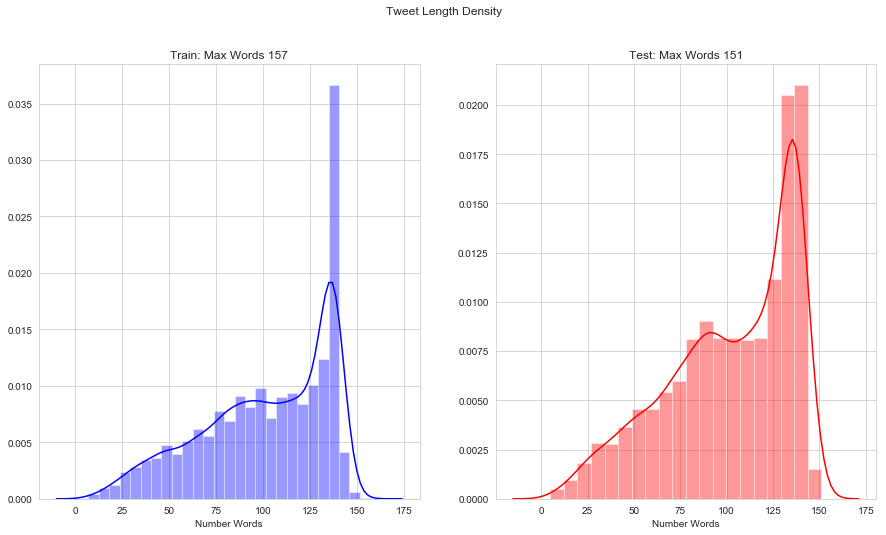

In [647]:
# Figure Size
figure, axis = plt.subplots(1,2, figsize=(15,8))

# Confic
plt.rcParams["patch.force_edgecolor"] = True   
sns.set_style('whitegrid')

# Axis Titles
print('\n')
# Main Title
figure.suptitle('Tweet Length Density')

# Labels
axis[0].set_title('Train: Max Words {}'.format(max(train_word_density)))
axis[0].set_xlabel('Number Words')

axis[1].set_title('Test: Max Words {}'.format(max(test_word_density)))
axis[1].set_xlabel('Number Words')

# Train
sns.distplot(train_word_density, kde = True, rug = False, color = 'blue', bins = None, hist = True, ax = axis[0]);

# Test
sns.distplot(test_word_density, kde = True, rug = False, color = 'red', bins = None, hist = True, ax = axis[1]);


# Show Plot
plt.show()

### LSTM: Creating Word Bank

In [650]:
# Defining X: text_data, y: target_data
text_data = data['text']
target_data = data.target

# Word Count
all_words = []
for tweet in text_data:
    for word in tweet:
        all_words.append(word)
word_count = pd.DataFrame(all_words).iloc[:,0].value_counts()

print('Number Unique Words: {}'.format(len(word_count.index)))

Number Unique Words: 22127


In [651]:
# Top Words 
max_num_words = 10000
top_words = word_count.index[0:max_num_words]

# Creating Word Dictionary 
word_dict = []
counter = 0
for word in top_words:
    word_dict.append([word,counter])
    counter += 1
    
word_dict = dict(word_dict)


"""
Notes:
Any word that is outside of the range (5000) will be replace by 5000
""";


### LSTM: Converting Word -> Numerical

In [652]:
# Define Our Function
def convert(l,d):
    new_l = []
    for word in l:
        try:
            new_l.append(d[word])
        except:
            new_l.append(max_num_words)
    return new_l

# Convert To Numerical
text_data = text_data.apply(lambda x: convert(x, word_dict))

### LSTM: Padding

In [653]:
# Max Words (Defined by histograms above)

max_length = 157
def padding(l, np, max_length):
    for i in range(max_length - len(l)):
        l.insert(0,0)
    return l

text_data = text_data.apply(lambda x: padding(x,np,max_length))

In [655]:
# Reshaping
dummy = []
for row in text_data:
    dummy.append(np.reshape(row,(1,max_length)))
    
text_data = np.reshape(dummy,(7613,max_length))

### LSTM: Building Model

In [672]:
# Convert to numpy array
X_train, X_test, y_train, y_test = train_test_split(np.array(text_data), target_data, test_size=0.25, random_state=1)

In [675]:
# LSTM model
embedding_vecor_length = 16
model = Sequential()
model.add(Embedding(max_num_words+1, embedding_vecor_length, input_length=max_length))
model.add(LSTM(25))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)
        
"""
Notes:
This network is not fully optimized and strictly built to use as a baseline
""";

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_66 (Embedding)     (None, 157, 16)           160016    
_________________________________________________________________
lstm_62 (LSTM)               (None, 25)                4200      
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 26        
Total params: 164,242
Trainable params: 164,242
Non-trainable params: 0
_________________________________________________________________
None
Train on 5709 samples, validate on 1904 samples
Epoch 1/3
5709/5709 [==============================] - 24s 4ms/sample - loss: 0.6529 - acc: 0.5980 - val_loss: 0.5786 - val_acc: 0.7395
Epoch 2/3
5709/5709 [==============================] - 15s 3ms/sample - loss: 0.4562 - acc: 0.8054 - val_loss: 0.4543 - val_acc: 0.7983
Epoch 3/3
5709/5709 [==============================]

### LSTM: Producing Results

In [694]:
# Pre-process Copy
data = test.copy()

# Shuffle Data (For CV)
#data = data.sample(frac=1).head().reset_index(drop = True)

# Remove Punctuations, Numbers, Special Cases
data['text'] = data['text'].str.replace("[^a-zA-Z]", " ")

# Lower Case
data['text'] = data['text'].apply( lambda x: x.lower())

# Tokenize
data['text'] = data['text'].apply( lambda x: x.split())

# Convert To Numerical
text_data = data['text'].apply(lambda x: convert(x, word_dict))

# Padding
text_data = text_data.apply(lambda x: padding(x,np,max_length))

# Reshaping
dummy = []
for row in text_data:
    dummy.append(np.reshape(row,(1,max_length)))
    
text_data = np.reshape(dummy,(3263,max_length))

In [695]:
preds = model.predict(text_data)
final = []
for val in preds:
    if val >= .50:
        final.append(1)
    else:
        final.append(0)
        
results = pd.DataFrame()
results['id'] = test['id'].copy()
results['target'] = final

results.to_csv('lstm.csv', index = False)

# .7843 accuracy